In [1]:
import cira 
import pandas as pd 
from datetime import datetime

cira.auth.KEY_FILE = "../../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"




IS_CACHED = True
SYMBOL = "MSFT"
SYM_HIST_FILE = f"./{SYMBOL}.csv"

stk = cira.Stock(SYMBOL)

if not IS_CACHED:
    start = datetime(2015, 7, 1)
    end = datetime(2023, 7, 1)
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,MSFT,48.18,48.61,47.36,48.61,59379610.0,272783.0,48.05
2016-01-05 05:00:00+00:00,MSFT,48.72,49.13,48.38,48.83,36457804.0,180639.0,48.83
2016-01-06 05:00:00+00:00,MSFT,48.18,48.25,47.58,47.94,41899187.0,225858.0,47.99
2016-01-07 05:00:00+00:00,MSFT,46.75,47.44,46.19,46.28,61897908.0,303273.0,46.64
2016-01-08 05:00:00+00:00,MSFT,46.45,47.26,46.26,46.42,52260304.0,261924.0,46.74


<Axes: xlabel='timestamp'>

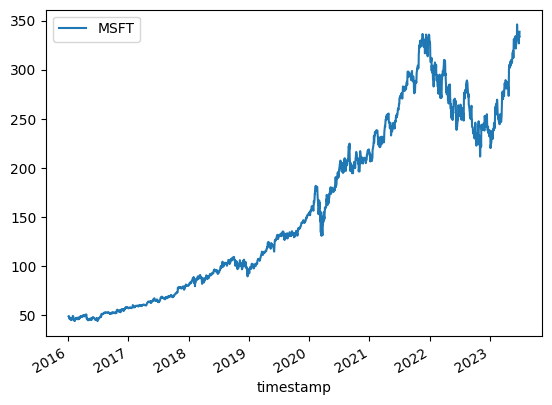

In [2]:

data.plot.line(y="close", use_index=True, label=SYMBOL)

In [3]:
split_prc = 0.9
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

1886 1697 189


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

model = LinearRegression()

features = ['open', 'high', 'low', 'volume', 'trade_count', 'vwap']
target = "close"
X = train_data[features].values
y = train_data[target].values

model.fit(X, y)

X_test = test_data[features].values
y_test = test_data[target].values

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.0981453112234119


In [5]:
import numpy as np
from typing import List
from pandas import DataFrame

from cira.strategy import Strategy


class MyStrat(Strategy):
    def __init__(self, model=LinearRegression, risk = 0.02) -> None:
        super().__init__(name="MyStrat")
        self.model = model
        self.win_probability = 0.6
        self.win_loss_ratio = 2
        self.risk = risk
        self.sizeings = {"position_size":[]}

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: np.ndarray, cash:float) -> np.ndarray:
        pred = self.model.predict(feature_data.values)
        sizeing = self.size(prices["close"][-1], pred[-1], cash, portfolio[-1])
        self.sizeings["position_size"].append(sizeing)
        return np.array([sizeing])

    def size(self, entry_price, predicted_price, cash, current_holding):
        return int(((predicted_price - entry_price)*(cash * (current_holding + 1 ) * self.risk )) / entry_price)

    
   

<Axes: xlabel='timestamp'>

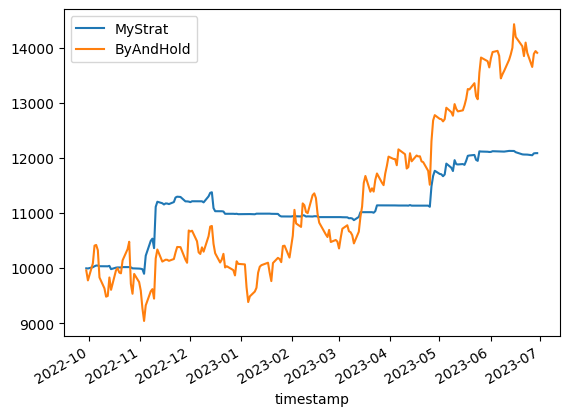

In [20]:
from cira.strategy.backtest import back_test_against_buy_and_hold as back_test
from cira.strategy.strategy import ByAndHold

strat = MyStrat(model, risk=0.08)
prices_df = my_dataframe = pd.DataFrame(test_data[target], columns=['close'])
results = back_test(strat, test_data[features], prices_df, 10_000)
results.plot()


<Axes: >

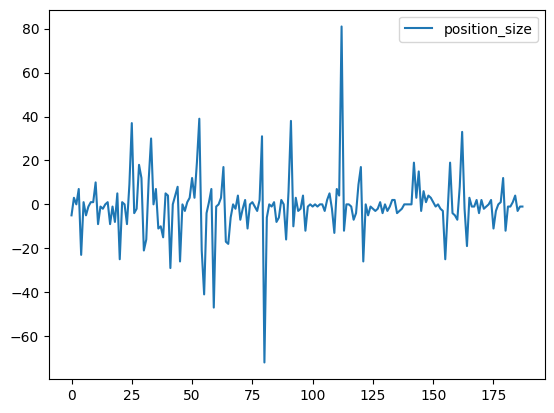

In [21]:
pd.DataFrame(strat.sizeings).plot()